In [71]:
import numpy as np
import pandas as pd
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

In [72]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.explainability.tft_explainer import TFTExplainer
from darts.utils.likelihood_models import QuantileRegression
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

## The objective of this notebook is to illustrate the power of the Temporal Fusion Transformer in forcasting using the equations of motion of a simple pendulum to predict the motion after 3/4 of a period. A Transformer is what is traditionally called "AI", a mostly buzzword for a certain class of models. This will be using the Darts Python library. 

### Install darts if needed. Install prophet first on mac
1) pip install prophet
2) pip install darts

In [73]:
#!pip install prophet
#!pip install darts

### Create a function to calculate motion of pendulum given length of pendulum string, number of desired periods modify the initial angle and the number of times during the number of periods

In [74]:
def create_pendulum_data(length, 
                         number_of_periods=1, 
                         initial_angle=0.1745329,
                         num_times = 100
                        ):
    # calculate one period
    one_period = 2*np.pi*np.sqrt(length/9.81)
    print("one period is: ", one_period)
    
    # calculate the maximum time
    max_time = number_of_periods*one_period
    
    # calculate time grid
    times = np.linspace(0.0, max_time, num_times)
    
    # calculate partial argument of position angle
    t_ = np.sqrt(9.81/length)
    
    # calculate resultant positions
    angles = initial_angle*np.cos(t_*times)
    
    # calculate accelerations
    accelerations = -9.81*np.sin(angles)
    
    # calculate velocities
    velocities = -initial_angle*t_*np.sin(t_*times)
    
    
    return angles, velocities, accelerations, times

### Choose a pendulum length of 10 and 1 period to analyze

In [75]:
angles, angular_velocities, angular_accelerations, times = create_pendulum_data(10.0, number_of_periods=1.0)

one period is:  6.343739849219413


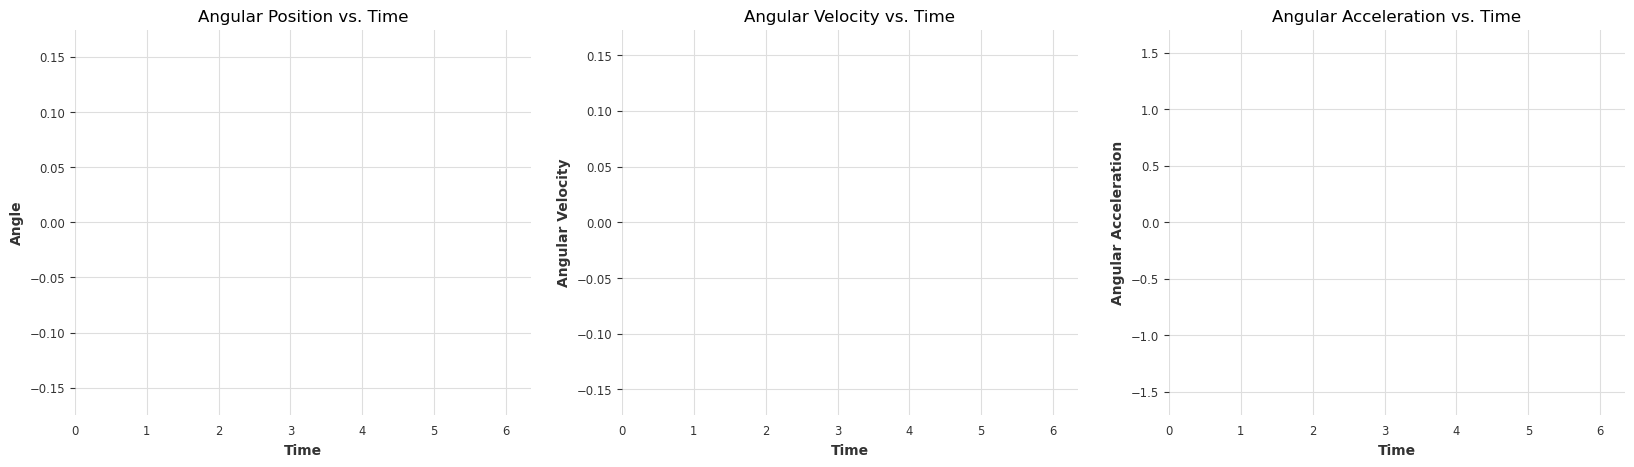

In [76]:
# creating a quick animation
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax[0].axis([0, np.max(times), np.min(angles), np.max(angles)])
l, = ax[0].plot([],[])
ax[1].axis([0, np.max(times), np.min(angular_velocities), np.max(angular_velocities)])
m, = ax[1].plot([],[])
ax[2].axis([0, np.max(times), np.min(angular_accelerations), np.max(angular_accelerations)])
n, = ax[2].plot([],[])

ax[0].title.set_text('Angular Position vs. Time')
ax[1].title.set_text('Angular Velocity vs. Time')
ax[2].title.set_text('Angular Acceleration vs. Time')

ax[0].set_xlabel("Time")
ax[1].set_xlabel("Time")
ax[2].set_xlabel("Time")

ax[0].set_ylabel("Angle")
ax[1].set_ylabel("Angular Velocity")
ax[2].set_ylabel("Angular Acceleration")

def animate(i):
    l.set_data(times[:i], angles[:i])
    m.set_data(times[:i], angular_velocities[:i])
    n.set_data(times[:i], angular_accelerations[:i])

ani = FuncAnimation(fig, animate, frames=len(times))

HTML(ani.to_jshtml())

### Create a pandas dataframe of the data.

In [89]:
experimental_data = pd.DataFrame()
experimental_data['times']= times
experimental_data['angular_accelerations'] = angular_accelerations
experimental_data['angular_velocities'] = angular_velocities
experimental_data['angles'] = angles
experimental_data['time_index'] = np.arange(0, experimental_data.shape[0], 1)

In [90]:
experimental_data.shape

(100, 5)

#### Split the time series into two. Our cutoff will be 4.5. This is a little before the last quarter of the motion starts; something the TFT will have not seen before

In [91]:
relevant_time_index = experimental_data.loc[experimental_data.times <= 4.5, "time_index"].values[-1]
print("start of validation time series: ", relevant_time_index)
length_of_validation = experimental_data.shape[0]-relevant_time_index
print("length of validation: ", length_of_validation)
time_mapping = experimental_data.loc[:, ['time_index', 'times']]
experimental_data = experimental_data.drop('times', axis=1)
darts_time_series_object = TimeSeries.from_dataframe(experimental_data, time_col="time_index")
train, val = darts_time_series_object.split_after(relevant_time_index)

start of validation time series:  70
length of validation:  30


### Scaling the data

In [92]:
transformer = Scaler()
transformer.fit(darts_time_series_object)
val_transformed = transformer.transform(val)
train_transformed = transformer.transform(train)
series_transformed = transformer.transform(darts_time_series_object)

### Creating the model instance

In [93]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 2
forecast_horizon = 1

# Apply early stopping
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=1000,
    min_delta=0.05,
    mode='min',
)
pl_trainer_kwargs={"callbacks": [my_stopper]}


# initialize model
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=128,
    lstm_layers=2,
    num_attention_heads=4,
    dropout=0.2,
    batch_size=16,
    n_epochs=3000,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42,
    pl_trainer_kwargs=pl_trainer_kwargs
)

In [94]:
my_model.fit(train_transformed, future_covariates=series_transformed, verbose=True)

Training: |                                               | 0/? [00:00<?, ?it/s]

TFTModel(hidden_size=128, lstm_layers=2, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.2, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=2, output_chunk_length=1, batch_size=16, n_epochs=3000, add_encoders=None, random_state=42, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x1a3e0b710>]})

In [95]:
def eval_model(model, 
               n, 
               actual_series, 
               train_series,
               val_series, 
               num_samples, 
               quantity
              ):
    
    # drop columns we are not interested in
    list_of_quantities = list(actual_series.columns)
    list_of_dropped_columns = [x for x in list_of_quantities if (x != quantity) & (x != 'time_index')]

    # plot actual series
    figsize = (10, 5)
    plt.figure(figsize=figsize)
    actual_series = val_series.drop_columns(list_of_dropped_columns)
    actual_series.plot(label="actual")
    
    # predict on validation set
    pred_series = model.predict(n=n, num_samples=num_samples)
    pred_series = pred_series.drop_columns(list_of_dropped_columns)

    
    # plot prediction with quantile ranges
    lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
    label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
    label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    # print(val_series.duration, pred_series.duration)
    plt.title(quantity)
    plt.legend()

Predicting: |                                             | 0/? [00:00<?, ?it/s]

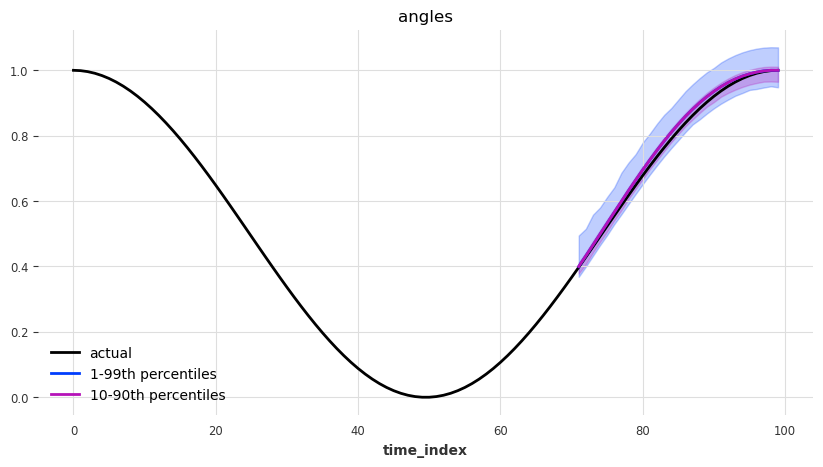

In [96]:
eval_model(my_model, 
           length_of_validation-1, 
           series_transformed, 
           train_transformed,
           series_transformed, 
           1000, 
           "angles"
          )

Predicting: |                                             | 0/? [00:00<?, ?it/s]

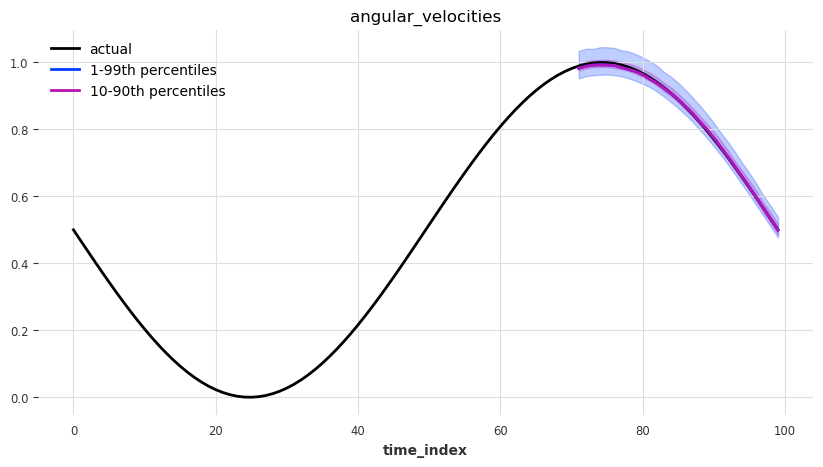

In [97]:
eval_model(my_model, 
           length_of_validation-1, 
           series_transformed, 
           train_transformed,
           series_transformed, 
           1000, 
           "angular_velocities"
          )

Predicting: |                                             | 0/? [00:00<?, ?it/s]

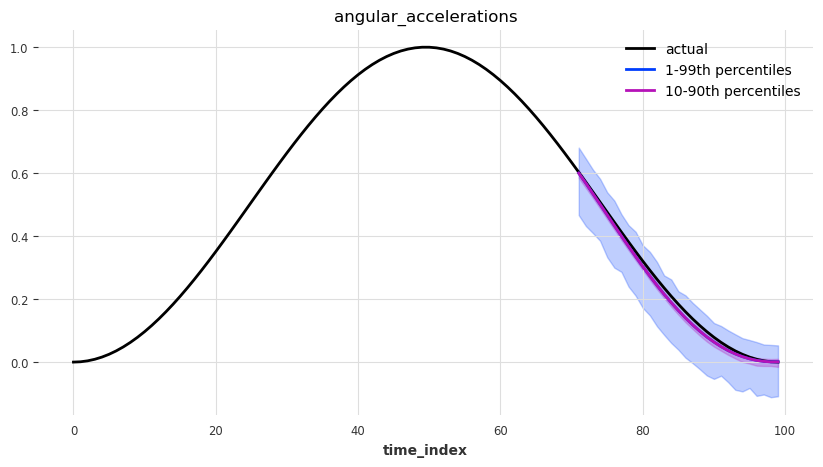

In [98]:
eval_model(my_model, 
           length_of_validation-1, 
           series_transformed, 
           train_transformed,
           series_transformed, 
           1000, 
           "angular_accelerations"
          )

### A very important note: The transformer has never seen the last fourth of the motion; it holds quantities of motion it has never seen before in this combination. This is powerful. It has learned the physical behavior of the pendulum.

### We can also look at the covariate importance

Predicting: |                                             | 0/? [00:00<?, ?it/s]

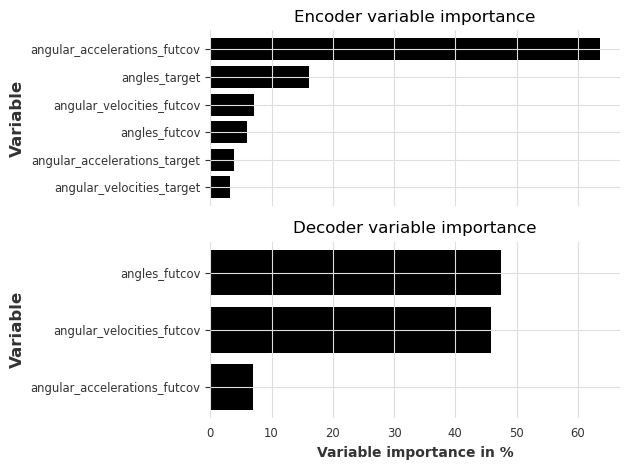

In [99]:
explainer = TFTExplainer(my_model)
results = explainer.explain()
explainer.plot_variable_selection(results)